In [2]:
import sys
print(sys.executable)

/home/mstryja/.conda/envs/stryja_sat/bin/python


In [2]:
import numpy as np
# Master lib:
from master_lib.utils import files_and_directories
from master_lib.image_processing.processing import dicom_to_array
from master_lib.loader.data_loader import evaluate_categories

# Rest
import pandas as pd
from master_lib.model.generator import DataGenerator
from typing import List

# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
from keras.layers import Input, Conv2D

# Preprocessing and additionals:
from sklearn.preprocessing import MinMaxScaler
from skimage import exposure
scaler = MinMaxScaler()

import cv2

import random

num_classes = 4

# matplotlib: 
import matplotlib.pyplot as plt

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"]="1"

model_archive = '../trained_models/'

In [4]:
class Dataset:
    
    # CLASSES = ['Atypical Appearance', 'Indeterminate Appearance', 'Negative for Pneumonia', 'StudyInstanceUID', 'Typical Appearance', 'boxes', 'label']
    CLASSES = ['Atypical Appearance', 'Indeterminate Appearance', 'Negative for Pneumonia','Typical Appearance']
    def __init__(self, list_of_images, classes=None): #, """augmentation=None, preprocessing=None, resize=None, gray=None"""):
        self.images = list_of_images
        self.labels = [evaluate_categories(os.path.basename(img), cols=self.CLASSES) for img in self.images]
        
    def __getitem__(self, i):
        img = dicom_to_array(self.images[i])
        label = self.labels[i]
        
        return img, label
        
    def __len__(self):
        return len(self.images)
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=8, input_shape=(1024, 1024) ,preprocessing=None, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocessing = preprocessing
        self.input_shape = input_shape
        # self.patch_size = patch_size
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            image, label = self.dataset[j][0], self.dataset[j][1]
            image = cv2.resize(image, self.input_shape, interpolation = cv2.INTER_AREA)
            if self.preprocessing:
                # Histogram equalization
                # image, label = self.dataset[j][0], self.dataset[j][1]
                image = exposure.equalize_hist(image)
                data.append([image, label])
            else:
                data.append([image, label])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        # print(batch.shape)
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

In [5]:
def dataset_partition(train_images_path_list: List, coef: float = 0.3, evaluation_cases: int = 150, verbose: int = 1):
    max_idx = len(train_images_path_list)-evaluation_cases
    up = int(np.ceil(max_idx*(1 - coef)))
    if verbose==1:
        o = f"dataset length: {len(train_images_path_list)}\nEvaluation Cases: {evaluation_cases}"
        o += f"\nTrain cases: {up}\nValidation cases: {max_idx - up}"
        print(o)
    return train_images_path_list[:up], train_images_path_list[up:max_idx], train_images_path_list[max_idx:]
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1)

filepath = r'C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, 'model5_equalization_hist_checkpoints'), monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

In [6]:
dataset_path = '../dataset.json'
dataset = files_and_directories.load_json(dataset_path)
dataset_images = '../../../covid_dataset/'
dataset = files_and_directories.load_json(dataset_path)
train_imgs = files_and_directories.list_train_images(dataset_images)
Xtrain, Xval, Xeval = dataset_partition(train_imgs)

dataset length: 6054
Evaluation Cases: 150
Train cases: 4133
Validation cases: 1771


In [7]:
train_dataset = Dataset(Xtrain)
validation_dataset = Dataset(Xval)
test_dataset = Dataset(Xeval)

In [8]:
idxs = random.sample(range(0, len(Xtrain)), 9)
for idx in idxs:
    print(train_dataset[idx][0].shape)

(2539, 3050)
(2260, 2527)
(2482, 3032)
(2436, 3032)
(2618, 3005)
(2828, 2320)
(3488, 4256)
(2336, 2836)
(2336, 2836)


[1529, 1365, 368, 1481, 1134, 2665, 3967, 1918, 3749]


/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


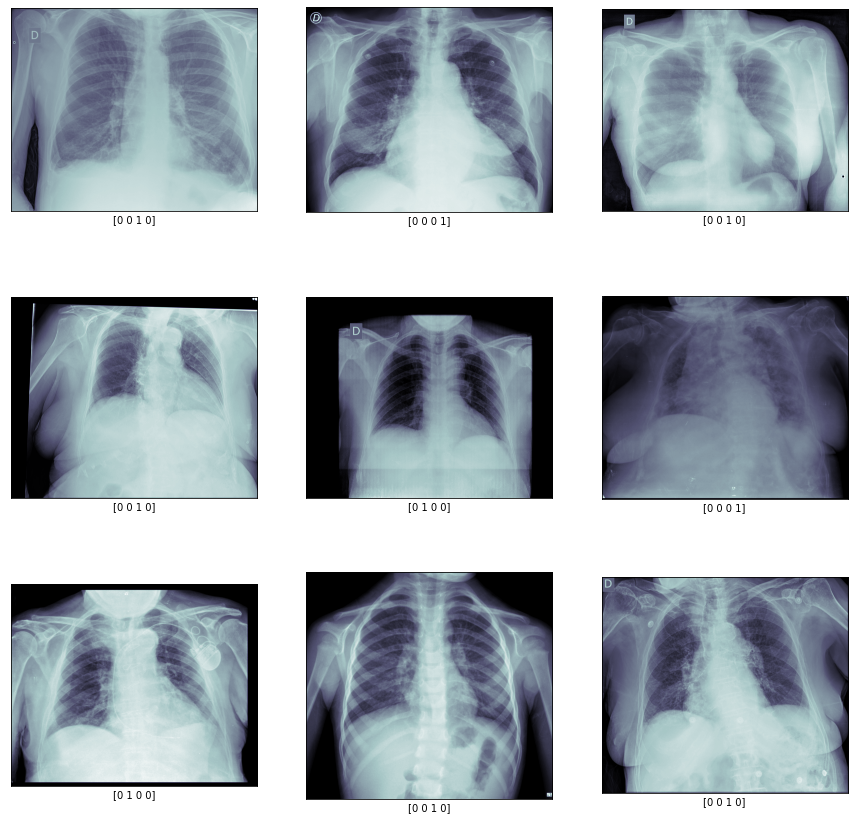

In [10]:
idxs = random.sample(range(0, len(Xtrain)), 9)
print(idxs)
fig, axs = plt.subplots(3,3, figsize=(15, 15))

row = col = 0
for idx in idxs:
    if col==3:
        row += 1
        col = 0
        
    img = train_dataset[idx][0]
    # scaler.fit(img)
    # img = scaler.transform(img)
    axs[row, col].imshow(img, cmap=plt.cm.bone)
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])
    axs[row, col].set_xlabel(train_dataset[idx][1])
    col+=1

[2304, 1865, 2710, 1290]


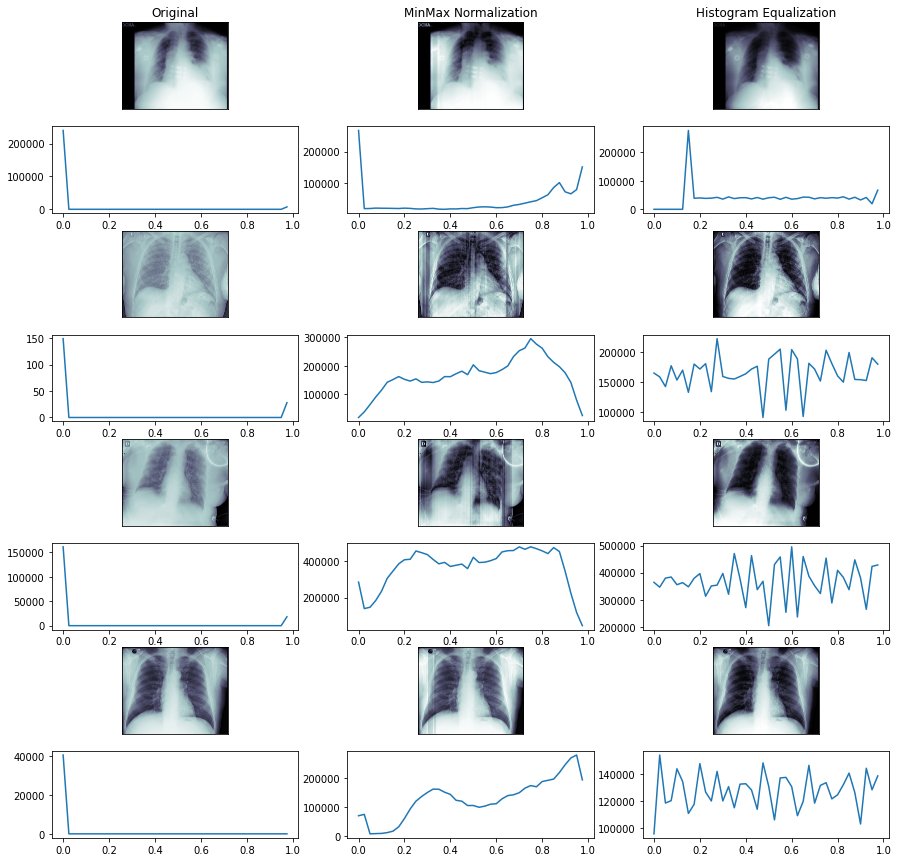

In [44]:
idxs = random.sample(range(0, len(Xtrain)), 4)
print(idxs)
fig, axs = plt.subplots(8, 3, figsize=(15,15))

cols = ['Original', 'MinMax Normalization', 'Histogram Equalization']
for col, ax in zip(cols, axs[0]):
    ax.set_title(col)
    
count = 0
for i, idx in enumerate(idxs):
    bins = 40
    img = train_dataset[idx][0]
    h_orig, bin_orig = np.histogram(img, bins=bins, range=(0, 1))
    axs[count,0].imshow(img, cmap=plt.cm.bone)
    axs[count+1,0].plot(bin_orig[0:-1], h_orig)
    # Minmax
    scaler.fit(img)
    img_minmax = scaler.transform(img)
    h_minmax, bin_minmax = np.histogram(img_minmax, bins=bins, range=(0, 1))
    axs[count,1].imshow(img_minmax, cmap=plt.cm.bone)
    axs[count+1,1].plot(bin_minmax[0:-1], h_minmax)
    # Equalization
    img_eq = exposure.equalize_hist(img)
    h_eq, bin_eq = np.histogram(img_eq, bins=bins, range=(0, 1))
    axs[count,2].imshow(img_eq, cmap=plt.cm.bone)
    axs[count+1,2].plot(bin_eq[0:-1], h_eq)
    for j in range(3):
        axs[count,j].set_xticks([])
        axs[count,j].set_yticks([])
        
    count += 2

In [25]:
train_generator = Dataloder(train_dataset, batch_size=16, preprocessing=True, shuffle=True)
valid_generator = Dataloder(validation_dataset, batch_size=2, preprocessing=True, shuffle=False)

1.0 0.00032806396484375
1.0 0.030130386352539062
1.0 0.07582759857177734
1.0 0.0023984909057617188
1.0 0.0005121231079101562
1.0 0.007187843322753906
1.0 0.0034914016723632812
1.0 0.03965568542480469


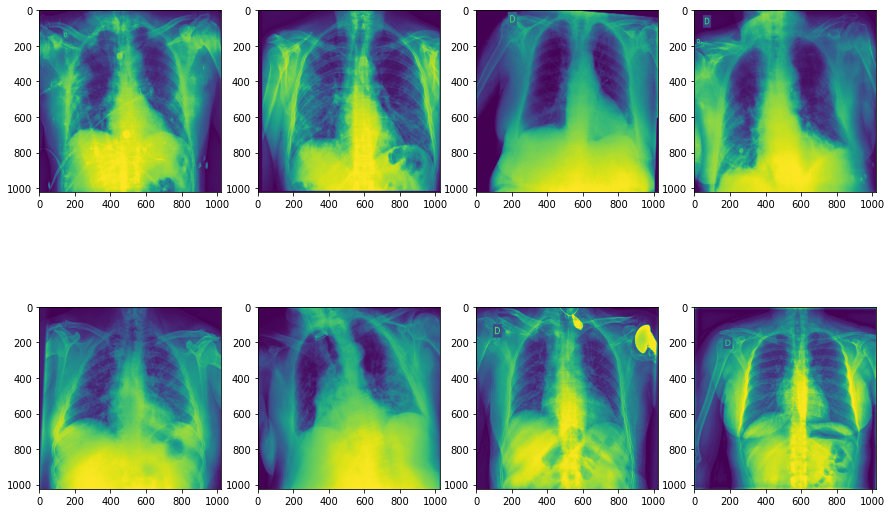

In [18]:
train_generator[0]
# Generator check:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
row = col = 0
for i, image in enumerate(train_generator[0][0]):
    if i<4:
        axs[0, i].imshow(image)
        print(image.max(), image.min())
        
    else:
        axs[1, i-4].imshow(image)
        print(image.max(), image.min())

In [126]:
model5 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(1024, 1024, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="third_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="fourth_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(8, (3, 3), padding='same', activation='relu', name="fith_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [127]:
model5_name = 'Sequential_equalization_preprocessing'

model5.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 1024, 1024, 1)     0         
                                                                 
 first_conv2d_filter (Conv2D  (None, 1024, 1024, 16)   416       
 )                                                               
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 512, 512, 16)     0         
 2D)                                                             
                                                                 
 second_conv2d_filter (Conv2  (None, 512, 512, 32)     12832     
 D)                                                              
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                  

In [129]:
model5.fit(train_generator,
        epochs=7,
        validation_data=valid_generator,
        verbose=1,
        callbacks=[early_stop, learning_rate, checkpoint])

model5.save(os.path.join(model_archive, model5_name))


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/7
185/516 [=========>....................] - ETA: 9:40 - loss: 1.2474 - accuracy: 0.4676

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2232 - accuracy: 0.4726
Epoch 00001: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints


2022-01-14 23:14:48.114652: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1205s 2s/step - loss: 1.2232 - accuracy: 0.4726 - val_loss: 1.2368 - val_accuracy: 0.4661 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/7
250/516 [=============>................] - ETA: 7:14 - loss: 1.2343 - accuracy: 0.4570

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2101 - accuracy: 0.4741
Epoch 00002: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1205s 2s/step - loss: 1.2101 - accuracy: 0.4741 - val_loss: 1.2289 - val_accuracy: 0.4661 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/7
191/516 [==========>...................] - ETA: 9:26 - loss: 1.2034 - accuracy: 0.4719

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2105 - accuracy: 0.4741
Epoch 00003: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1203s 2s/step - loss: 1.2105 - accuracy: 0.4741 - val_loss: 1.2273 - val_accuracy: 0.4661 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/7
414/516 [=======================>......] - ETA: 2:46 - loss: 1.2112 - accuracy: 0.4722

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2101 - accuracy: 0.4741
Epoch 00004: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1204s 2s/step - loss: 1.2101 - accuracy: 0.4741 - val_loss: 1.2268 - val_accuracy: 0.4661 - lr: 0.0010

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/7
504/516 [============================>.] - ETA: 19s - loss: 1.2105 - accuracy: 0.4745

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.4741
Epoch 00005: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1197s 2s/step - loss: 1.2096 - accuracy: 0.4741 - val_loss: 1.2304 - val_accuracy: 0.4661 - lr: 0.0010

Epoch 00006: LearningRateScheduler setting learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
Epoch 6/7
183/516 [=========>....................] - ETA: 8:53 - loss: 1.2031 - accuracy: 0.4836

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2107 - accuracy: 0.4741
Epoch 00006: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1202s 2s/step - loss: 1.2107 - accuracy: 0.4741 - val_loss: 1.2275 - val_accuracy: 0.4661 - lr: 9.0484e-04

Epoch 00007: LearningRateScheduler setting learning rate to tf.Tensor(0.0008187307, shape=(), dtype=float32).
Epoch 7/7
492/516 [===========================>..] - ETA: 39s - loss: 1.2072 - accuracy: 0.4759

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


516/516 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.4741
Epoch 00007: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints/model5_equalization_hist_checkpoints/assets
516/516 [==============================] - 1204s 2s/step - loss: 1.2093 - accuracy: 0.4741 - val_loss: 1.2277 - val_accuracy: 0.4661 - lr: 8.1873e-04
INFO:tensorflow:Assets written to: ../trained_models/Sequential_equalization_preprocessing/assets


In [131]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
epochs = model5.history.epoch
keys = model5.history.history.keys()
loss = model5.history.history['loss']
val_loss = model5.history.history['val_loss']
acc = model5.history.history['accuracy']
val_acc = model5.history.history['val_accuracy']

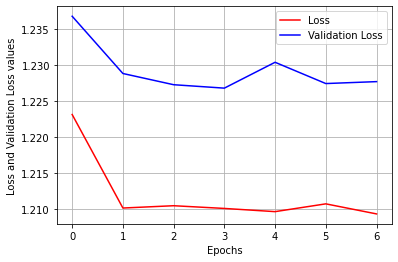

In [134]:
plt.plot(epochs, loss, 'r-', label='Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss and Validation Loss values')
plt.grid()
plt.xticks(epochs)
plt.legend()



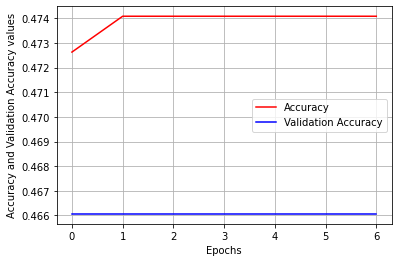

In [135]:
plt.plot(epochs, acc, 'r-', label='Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Validation Accuracy values')
plt.grid()
plt.xticks(epochs)
plt.legend()

In [26]:
# Resnet Model
resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=4)

In [27]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [36]:
inp = Input(shape=(1024, 1024, 1))
converter = Conv2D(3, (1, 1), trainable=False)(inp) # map N channels data to 3 channels
x = resnet(converter)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation =  tf.keras.activations.sigmoid
outputs = keras.layers.Dense(4,
                             kernel_initializer=initializer,
                             activation=activation)(x) 

metrics = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), keras.metrics.]

In [37]:
model = keras.Model(inp, outputs)

In [38]:
model.compile(optimizer=optim,
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=metrics)

In [39]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
172/258 [===================>..........] - ETA: 4:38 - loss: 0.5137 - categorical_accuracy: 0.4597

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


258/258 [==============================] - 1205s 5s/step - loss: 0.5079 - categorical_accuracy: 0.4714 - val_loss: 0.5313 - val_categorical_accuracy: 0.4667
Epoch 2/5
258/258 [==============================] - 1220s 5s/step - loss: 0.4716 - categorical_accuracy: 0.5460 - val_loss: 0.5496 - val_categorical_accuracy: 0.4667
Epoch 3/5
258/258 [==============================] - 1203s 5s/step - loss: 0.4422 - categorical_accuracy: 0.5916 - val_loss: 0.5228 - val_categorical_accuracy: 0.4667
Epoch 4/5
258/258 [==============================] - 1207s 5s/step - loss: 0.4287 - categorical_accuracy: 0.6080 - val_loss: 0.4878 - val_categorical_accuracy: 0.5136
Epoch 5/5
258/258 [==============================] - 1205s 5s/step - loss: 0.4140 - categorical_accuracy: 0.6233 - val_loss: 0.4451 - val_categorical_accuracy: 0.6090


In [45]:
path_to_model = os.path.join('/home/mstryja/projects/master_thesis_covid/trained_models', 'Conv2D_ResNet50')
model.save(path_to_model)

2022-01-15 18:51:34.608788: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/mstryja/projects/master_thesis_covid/trained_models/Conv2D_ResNet50/assets


/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [48]:
test_datagenerator = Dataloder(test_dataset, batch_size=1, preprocessing=True, shuffle=False)

In [51]:
scores = model.evaluate(test_datagenerator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.name, value))

150/150 [==============================] - 29s 194ms/step - loss: 0.4696 - categorical_accuracy: 0.5600
Loss: 0.46963
mean categorical_accuracy: 0.56


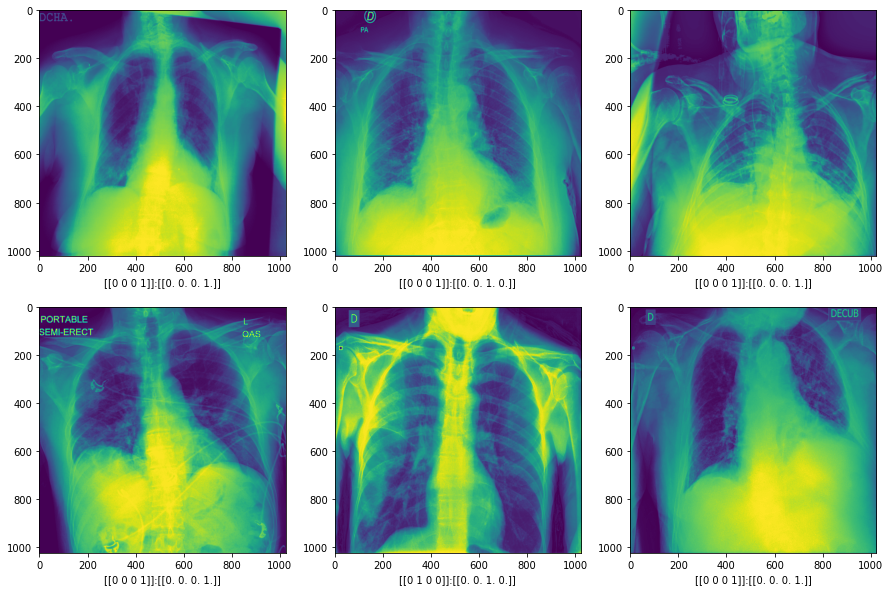

In [69]:
idxs = random.sample(range(0, len(test_dataset)), 6)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

row = col = 0
for idx in idxs:
    if col==3:
        row += 1
        col = 0
    image, label = test_datagenerator[idx][0], test_datagenerator[idx][1]
    axs[row, col].imshow(image[0])
    pred = model.predict(image).round()
    axs[row, col].set_xlabel(str(label) + ':' + str(pred))
    col+=1

In [7]:
# EfficientNet Model
# Data:
efnet_traingen = Dataloder(train_dataset, batch_size=4, input_shape=(224, 224), preprocessing=True, shuffle=True)
efnet_validgen = Dataloder(validation_dataset, batch_size=2, input_shape=(224, 224), preprocessing=True, shuffle=False)

In [8]:
from tensorflow.keras.applications import EfficientNetB0
# effnet_model = EfficientNetB7(weights='imagenet')

In [ ]:

inputs = layers.Input(shape=(224, 224, 1))
# x = img_augmentation(inputs)
converter_eff = Conv2D(3, (1, 1), trainable=False)(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=4)(converter_eff)

effnet_model = tf.keras.Model(inputs, outputs)
effnet_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


effnet_model.summary()
epochs = 5

hist = effnet_model.fit(efnet_traingen, epochs=epochs, validation_data=efnet_validgen, verbose=2)

2022-01-15 22:23:32.827550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-15 22:23:33.273225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38414 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       6         
                                                                 
 efficientnetb0 (Functional)  (None, 4)                4054695   
                                                                 
Total params: 4,054,701
Trainable params: 4,012,672
Non-trainable params: 42,029
_________________________________________________________________
Epoch 1/5


2022-01-15 22:23:44.259030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-01-15 22:23:45.609071: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [3]:
ResNet50??